In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import ast
import random


In [2]:
#Limpieza de BD

df_titles = pd.read_csv("titles.csv")

df_titles['imdb_score'].replace([np.nan], round(df_titles['imdb_score'].mean(),1), inplace=True)
df_titles['tmdb_score'].replace([np.nan], round(df_titles['tmdb_score'].mean(),1), inplace=True)
df_titles['tmdb_score'] = round(df_titles['tmdb_score'],1)

def repair_array_bound_categories(arr):
    arr = ast.literal_eval(arr)
    
    if len(arr) == 0:
        return np.nan
    
    elif len(arr) == 1:
        return arr[0]
    
    else:
        return random.choice(arr)


Mediante el siguiente EDA, vamos a ver cuales serian parametros a tener en cuenta para poder predecir contenido en la plataforma

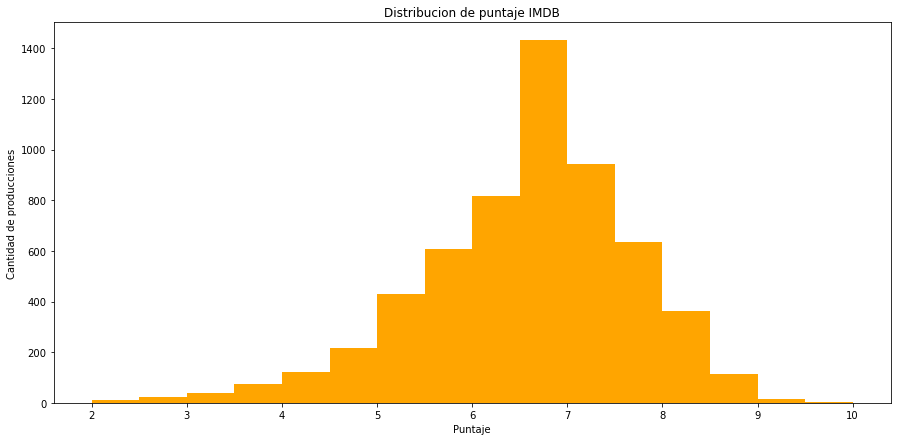

In [3]:
plt.figure(figsize=(15, 7))
plt.title('Distribucion de puntaje IMDB')
plt.xlabel('Puntaje')
plt.ylabel('Cantidad de producciones')

plt.hist(df_titles['imdb_score'], bins=np.arange(2,10.1,.5), color='orange')

plt.show()

Como podemos ver, el puntaje en la plataforma suele estar entre 6 y 8, por lo que podriamos inferir en que el contenido es de calidad.

C:\Users\FCDDA~1.GAR\AppData\Local\Temp/ipykernel_29120/293977391.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  countries = countries.str.replace("[","")
C:\Users\FCDDA~1.GAR\AppData\Local\Temp/ipykernel_29120/293977391.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  countries = countries.str.replace("]","")


'US'    2323
'IN'     622
'GB'     404
'JP'     287
'FR'     248
'KR'     228
'CA'     219
'ES'     211
'DE'     139
'MX'     126
'CN'     102
'BR'     102
'PH'      86
'TR'      84
'AU'      84
'IT'      83
'NG'      73
'AR'      72
'TW'      64
'ID'      63
dtype: Int64


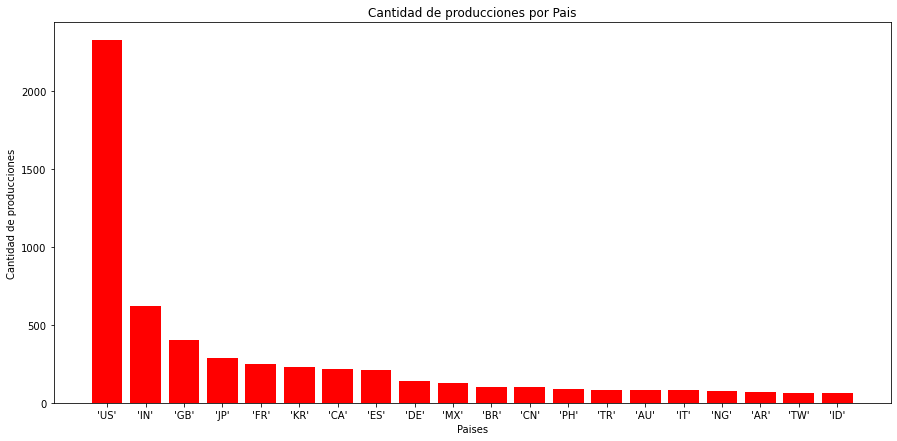

In [4]:
#Limpieza de columna countries

countries = df_titles['production_countries']
countries = countries.astype("string")
countries = countries.str.replace("[","")
countries = countries.str.replace(" ","")
countries = countries.str.replace("]","")
countries = countries.str.split(",",expand=True)

#Agrego todos los generos en una sola columna, en el df original, peliculas con mas de un pais en esta columna
countries_sumados = pd.Series("string")
for col in countries:
    countries_sumados = pd.concat([countries_sumados,countries[col]], ignore_index=True)
    
#Quito los varoles nulos y datos incongruentes
countries_sumados = countries_sumados.astype("string")
countries_sumados.sort_values()
countries_sumados = countries_sumados[countries_sumados != "NA"]
countries_sumados = countries_sumados[countries_sumados != "string"]
countries_sumados = countries_sumados[countries_sumados != ""]

#Creo una serie con las sumas ya hechas y, como son muchos los paises con producciones, solo presento los primeros 15

sumatoria = countries_sumados.value_counts().head(20)
print(sumatoria)

#Grafico los paises

plt.figure(figsize=(15, 7))

plt.title('Cantidad de producciones por Pais')
plt.xlabel('Paises')
plt.ylabel('Cantidad de producciones')

sumatoria.sort_values(inplace=True, ascending=False)

plt.bar(x= sumatoria.index, height=sumatoria, color='red',)

plt.show()

A su vez, la mayor cantidad de producciones son de Estados Unidos e India

In [5]:
#Limpieza de countries

df = df_titles

df["production_countries"] = df["production_countries"].apply(repair_array_bound_categories)

C:\Users\f.garciascorts\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


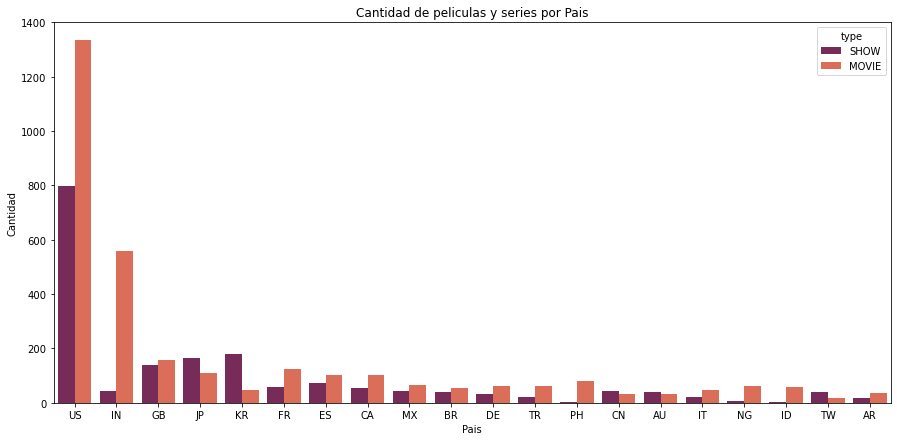

In [6]:
#Plot tipo y cant de prod por pais

plt.figure(figsize=(15,7))
sns.countplot(df['production_countries'], hue=df['type'], palette='rocket', order=df['production_countries'].value_counts().iloc[:20].index)
plt.title("Cantidad de peliculas y series por Pais")
plt.xlabel("Pais")
plt.ylabel("Cantidad")
plt.show()

Pero no necesariamente todo el contenido que nos interese pondera solamente de esos pais, algunos paises realizan mas producciones de un tipo que de otro. Asi que no se puede descartar por ejemplo que se presente contenido de mejor calidad o mas contenido de un pais que no tenga tantas producciones.

In [67]:
#mejores promedios de imdb por paises
calidad_pp = df[['imdb_score','production_countries']]
imdb_pp = calidad_pp.groupby(['production_countries']).mean().sort_values(by ="imdb_score",ascending= False).head(15)
imdb_pp.rename(columns={"imdb_score": "imdb_mean"})

,imdb_mean
production_countries,
AF,7.700000
PR,7.700000
CD,7.500000
NP,7.500000
HR,7.400000
IL,7.346154
DZ,7.200000
BD,7.150000
KR,7.129204


Como se puede ver figuran como principales algunos paises que solo tienen una pelicula, entonces buscamos que en aquellos paises que tengan como minimo 10 producciones.

In [114]:
#genero promedio de imdb teniendo en cuenta la cantidad de peliculas/series
df2 = calidad_pp[['imdb_score','production_countries']].groupby(['production_countries']).agg(['mean','count'])
#filtramos por mayor a 10 producciones  y ordenamos los primeros 10 mejores promedios
df3 = df2[df2[('imdb_score','count')] >10].sort_values(by=('imdb_score','mean'), ascending=False)[:10]
df3

imdb_score      
                           mean count
production_countries                 
IL                     7.346154    13
KR                     7.129204   226
PS                     7.063636    11
DK                     7.000000    20
JP                     6.976087   276
CN                     6.927848    79
GB                     6.885185   297
RU                     6.830769    13
BE                     6.712000    25
TW                     6.700000    59

Notamos que Islandia, Korea, Palestina, Dinamarca y Japon estan entre los de mayor indice imdb

In [1]:
#Plot calidad de prod por pais

plt.figure(figsize=(15,7))
sns.boxplot(x=df['production_countries'],
            hue=df['type'], 
            palette='rocket', 
            y=df['imdb_score'],
            order=df['production_countries'].value_counts().iloc[:20].index)
plt.title("Calidad de peliculas y series por Pais")
plt.xlabel("Pais")
plt.ylabel("Puntaje IMDB")
plt.show()

NameError: name 'plt' is not defined

C:\Users\ezesp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


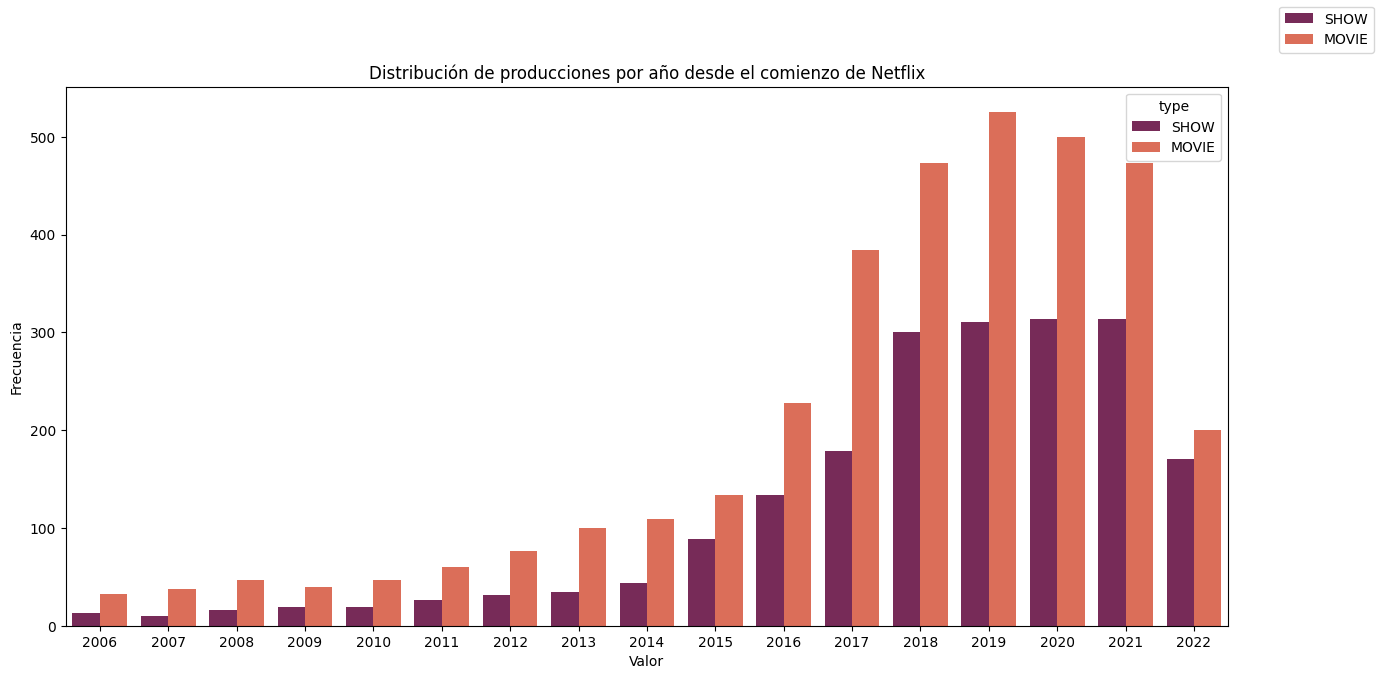

In [36]:
fig = plt.figure(figsize=(15,7))

sns.countplot(df_titles.release_year [df_titles.release_year >= 2006], hue=df_titles.type, palette='rocket')

fig.legend()
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución de producciones por año desde el comienzo de Netflix')
plt.show()


Tambien podemos ver que la mayoria de los contenidos pertenecen a los ultimos 6 años.

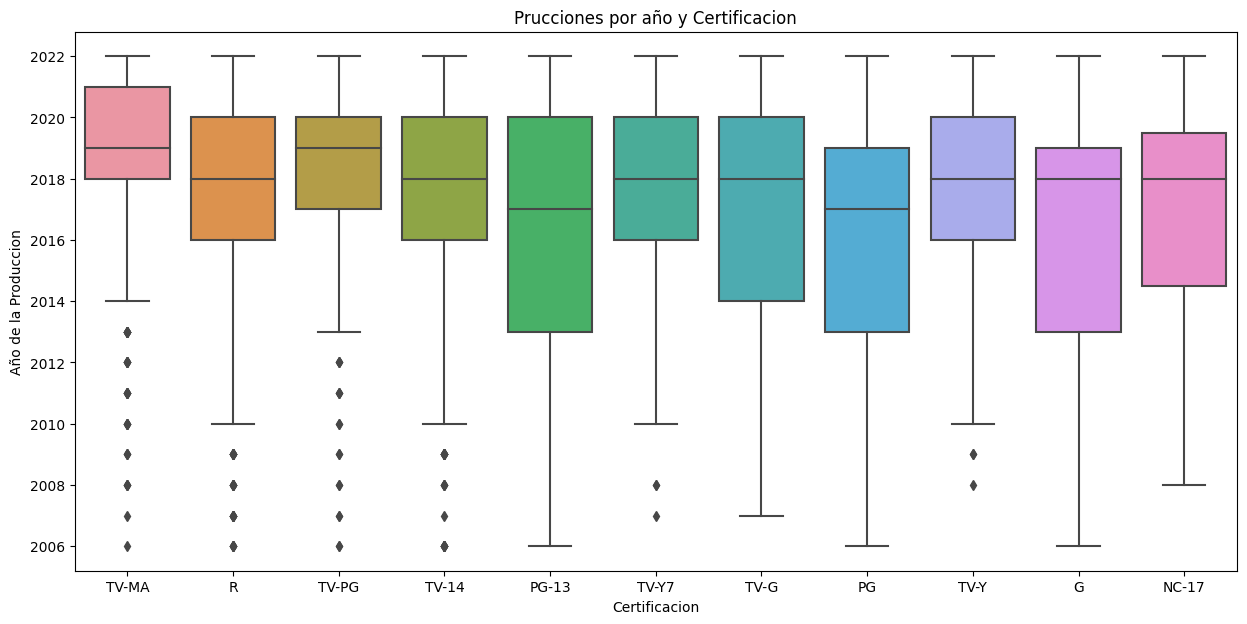

In [57]:

producciones = df_titles
producciones['release_year'] = producciones['release_year'].astype(int)
producciones = producciones[producciones['release_year'] >= 2006]

plt.figure(figsize=(15, 7))

plot = sns.boxplot(x=producciones['age_certification'], y=producciones['release_year'])

plot.set_title('Prucciones por año y Certificacion')
plot.set_ylabel('Año de la Produccion')
plot.set_xlabel('Certificacion')

plt.show()

Y que el contenido que mas prolifero en el utlimo tiempo son las series para adultos.

C:\Users\ezesp\AppData\Local\Temp\ipykernel_18500\954883090.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  generos = generos.str.replace("[","")
C:\Users\ezesp\AppData\Local\Temp\ipykernel_18500\954883090.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  generos = generos.str.replace("]","")


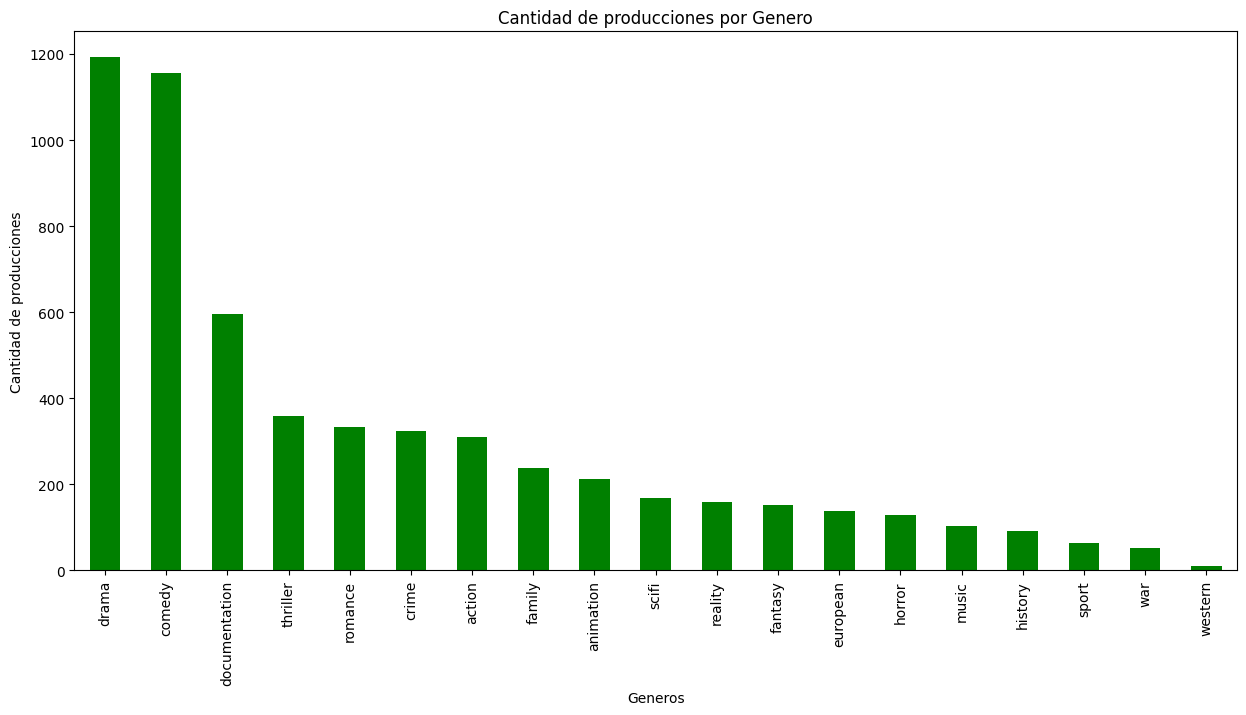

In [40]:
#Limpieza de columna generos

generos = df_titles['genres']
generos = generos.astype("string")
generos = generos.str.replace("[","")
generos = generos.str.replace(" ","")
generos = generos.str.replace("]","")
generos = generos.str.split(",",expand=True)
#Agrego todos los generos en una sola columna, en el df original, peliculas con mas de un genero en esta columna
generos_sumados = pd.Series("string")
for col in generos:
    generos_sumados = pd.concat([generos_sumados,generos[col]], ignore_index=True)
#Quito los varoles nulos y datos incongruentes
generos_sumados = generos_sumados.astype("string")
generos_sumados.sort_values()
generos_sumados = generos_sumados[generos_sumados != "<NA>"]
generos_sumados = generos_sumados[generos_sumados != "string"]
generos_sumados = generos_sumados[generos_sumados != ""]

#print(generos_sumados.value_counts())


#Grafico los generos

plt.figure(figsize=(15, 7))

plt.title('Cantidad de producciones por Genero')
plt.ylabel('Cantidad de producciones')
plt.xlabel('Generos')

generos_sumados.value_counts().sort_values(ascending=False).plot.bar(color= 'green')

plt.show()


A su vez, los generos mas producidos son drama y comedia.

In [23]:
#Limpieza de generos

df_generes = df_titles

df_generes["genres"] = df["genres"].apply(repair_array_bound_categories)

C:\Users\ezesp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


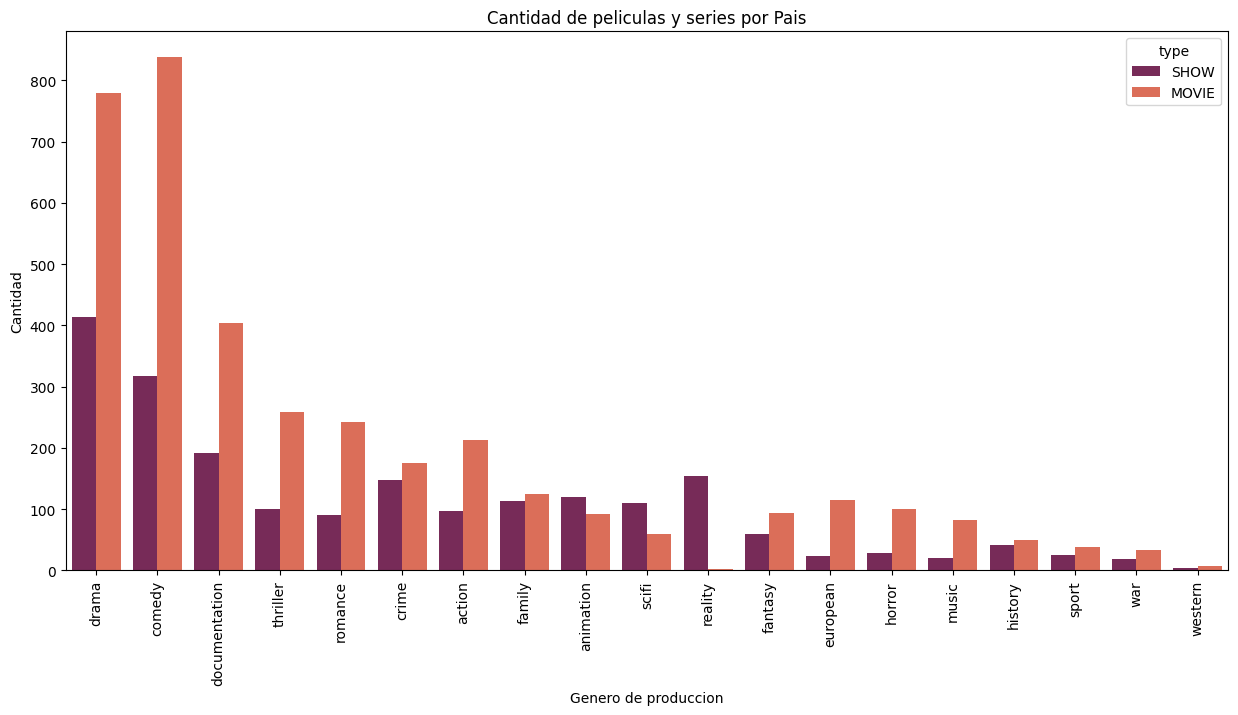

In [41]:
#Plot tipo y cant de prod por pais

plt.figure(figsize=(15,7))
sns.countplot(df_generes['genres'], hue=df_generes['type'], palette='rocket', order=df_generes['genres'].value_counts().iloc[:20].index)
plt.title("Cantidad de peliculas y series por Pais")
plt.xlabel("Genero de produccion")
plt.xticks(rotation= 90)
plt.ylabel("Cantidad")
plt.show()

Aunque tambien hay generos que practicamente no poseen cierto tipo de producciones o son muy pocas. Como Scifi que la mayoria son series. La ponderancia igual es que haya mayor cantidad de peliculas que de series.

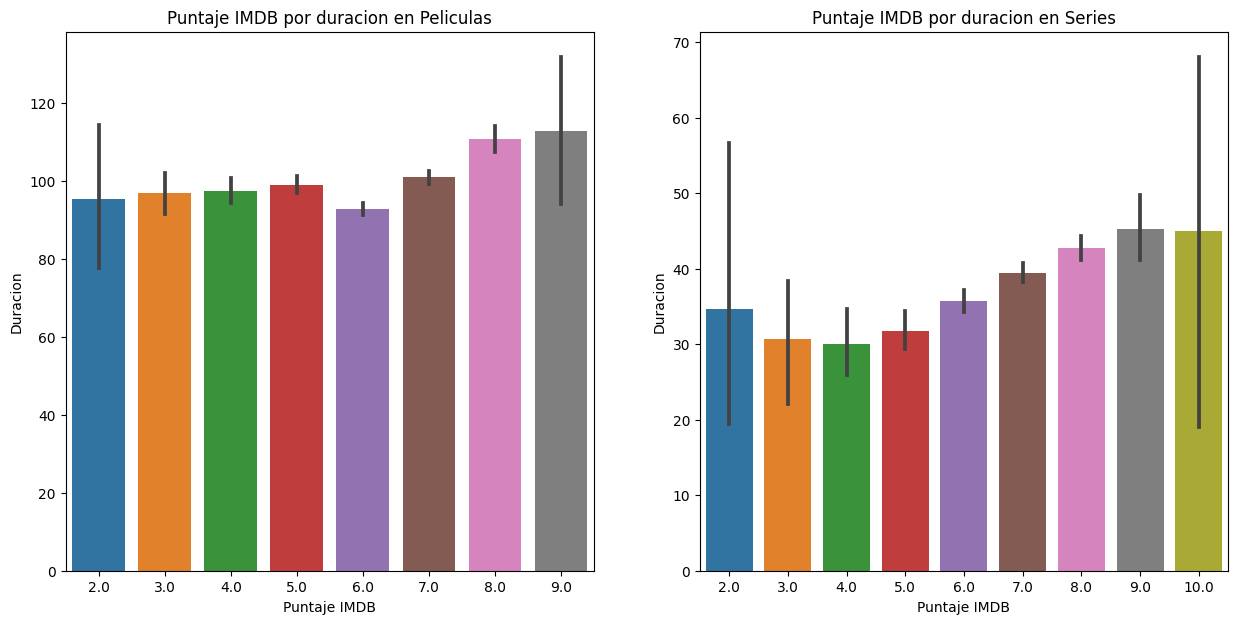

In [42]:
#Analisis de Puntaje imdb vs duracion en peliculas y series

fig, axes = plt.subplots(1, 2, figsize=(15,7))

puntajes = df_titles.round({'imdb_score': 0, 'tmdb_score':0})

peliculas = puntajes[puntajes['type'] =='MOVIE']
series = puntajes[puntajes['type'] =='SHOW']

plot_mov = sns.barplot(x='imdb_score', y='runtime', data=peliculas,ax=axes[0])

plot_mov.set_title('Puntaje IMDB por duracion en Peliculas')
plot_mov.set_ylabel('Duracion')
plot_mov.set_xlabel('Puntaje IMDB')

plot_show = sns.barplot(x='imdb_score', y='runtime', data=series, ax=axes[1])

plot_show.set_title('Puntaje IMDB por duracion en Series')
plot_show.set_ylabel('Duracion')
plot_show.set_xlabel('Puntaje IMDB')

plt.show()

Y a su vez, podemos inferir que la mayoria de los puntajes de las series de capitulos largos, es mayor que las de las series de capitulos cortos. Mientras que no se puede inferir lo mismo con las peliculas.